In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import model_based_agent as mba 
import worm_env as we 
import fake_worm as fw
import ensemble_mod_env as eme

from improc import *
import utils as ut
import tab_agents as tab
from datetime import datetime 

In [2]:
folds = ['./Data/Det03-02-13-16/',
        './Data/Det03-02-14-39/',
        './Data/Det03-02-15-48/',
        './Data/Learned02-02-13-48/',
        './Data/Learned02-02-18-29/',
        './Data/Learned02-02-19-43/',
        './Data/Random02-02-15-10/',
        './Data/Off03-02-11-37/',
        ]

In [3]:
def load_folder(fold,name,n=15):
    # Loads trajectories into a dict with lists of arrays. 
    trajs = []
    for i in range(n):
        with open(f'{fold}{name}{i}.pkl','rb') as f:
            trajs.append(pickle.load(f))
    
    t_dict = {}
    for k in trajs[0].keys():
        t_dict[k] = [np.array(trajs[i][k]).flatten() for i in range(n)]
        if k=='loc' or k=='obs':
            t_dict[k] = [t_dict[k][i].reshape(-1,2) for i in range(n)]
    return t_dict

In [68]:
dets = []
for d in np.arange(3):
    dets.append(load_folder(folds[d],'det'))
learneds = []
for l in np.arange(3)+3:
    learneds.append(load_folder(folds[l],name='learned'))
rands = load_folder(folds[-2],'random')
offs = load_folder(folds[-1],'off')

In [70]:
n=15
det_rs = [[np.mean(dets[j]['reward'][i]) for i in range(n)] for j in range(3)]
learned_rs = [[np.mean(learneds[j]['reward'][i]) for i in range(n)] for j in range(3)]
rand_rs = [np.mean(rands['reward'][i]) for i in range(n)]
off_rs = [np.mean(offs['reward'][i]) for i in range(n)]

In [71]:
mean_vec = [*[np.mean(det_rs[i]) for i in range(3)],*[np.mean(learned_rs[i]) for i in range(3)],
            np.mean(rand_rs),np.mean(off_rs)]
std_vec = [*[np.std(det_rs[i]) for i in range(3)],*[np.std(learned_rs[i]) for i in range(3)],
           np.std(rand_rs),np.std(off_rs)]
plot_vec = [-.05,0,.05,.95,1,1.05,2,3]

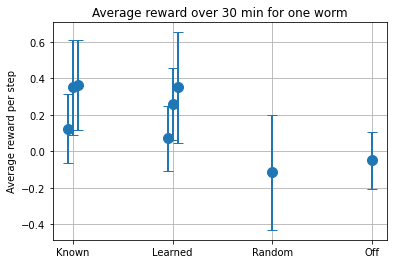

In [73]:
plt.errorbar(plot_vec,mean_vec,yerr=std_vec,marker='o',markersize=10,capsize=5,linewidth=0,elinewidth=2)
plt.grid();
plt.title('Average reward over 30 min for one worm')
plt.xticks([0,1,2,3],['Known','Learned','Random','Off']);
plt.ylabel('Average reward per step');

# Next for experiments:
#### Control: No light
#### More known and random worms

Online learning: goals are to learn timescale and efficiency. 

Can I learn the timescale from the current 3 hrs of random data?


# Learning timescale

In [4]:
files = ['./Data/HTFix19-01-18-47/',
           './Data/HTFix19-01-20-29/',
           './Data/HTFix19-01-21-18/',
           './Data/HTFix20-01-09-04/',
           './Data/HTFix20-01-09-42/',
           './Data/HTFix20-01-10-41/',
          ]
files = ['../01_13_reals/'+f[2:] for f in files]
t_files = []
for file in files:
    if file=='../01_13_reals/Data/HTFix19-01-21-18/':
        for i in range(3):
            t_files.append(f'{file}collect{i}.pkl')
    else:
        for i in range(6):
            t_files.append(f'{file}collect{i}.pkl')

In [5]:
r=1
dh = mba.DataHandler()
dh.params = {
            'reward_ahead': r,
            'timestep_gap': 1,
            'prev_act_window': 3,
            'jump_limit': 100,
        }
dh.add_dict_to_df(t_files,reward_ahead=r)
mset = eme.ModelSet(1,frac=1,lp_frac=None)
mset.make_models(dh,sm_pars={'lambda':.1,'iters':10})

# with open(f'model_ra_{r}.pkl','wb') as f:
#     pickle.dump(mset,f)

C:\Users\ccli3\Documents\Research\R_RamanathanLab\20_09_07_Repo\RLWorms\01_22_baselines\utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['angs'][i] = np.flip(df['angs'][i])


On model 0


In [6]:
# with open(f'model_ra_1_df.pkl','wb') as f:
#     pickle.dump(dh,f)

# Seeing differences between trajectories

In [96]:
def get_distances_travelled(folder_dict,n=15):
    # Takes in one folder's dictionary with list of trajectories.
    # n is number of runs in that folder.
    # Returns list of distances travelled, step by step, and removes jumps.
    det_locs = np.vstack([folder_dict['loc'][i] for i in range(n)])
    dists = []
    for i in range(len(det_locs)-1):
        dist = pt_dist(det_locs[i,:],det_locs[i+1,:])
        if dist < 20 and dist != 0:
            dists.append(dist)
    return dists

def get_all_dists(folder_dicts):
    # For multiple folders.
    dists = []
    for dl in folder_dicts:
        dists.append(get_distances_travelled(dl))   
    return np.array([item for sublist in dists for item in sublist])

In [115]:
dists_det = get_all_dists(dets)
dists_learned = get_all_dists(learneds)

dists_det1 = np.array(get_distances_travelled(dets[0]))
dists_learned1 = np.array(get_distances_travelled(learneds[0]))
dists_rands = np.array(get_distances_travelled(rands))
dists_offs = np.array(get_distances_travelled(offs))

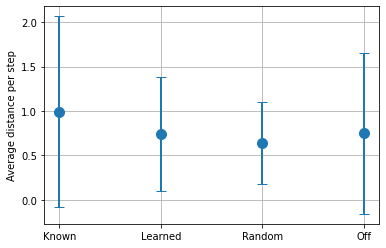

In [98]:
plt.errorbar([0,1,2,3],[np.mean(dists_det),np.mean(dists_learned),np.mean(dists_rands),np.mean(dists_offs)],
             yerr=[np.std(dists_det),np.std(dists_learned),np.std(dists_rands),np.std(dists_offs)],
             marker='o',markersize=10,capsize=5,linewidth=0,elinewidth=2);
plt.grid();
plt.xticks([0,1,2,3],['Known','Learned','Random','Off']);
plt.ylabel('Average distance per step');

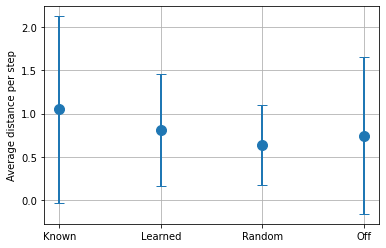

In [116]:
plt.errorbar([0,1,2,3],[np.mean(dists_det1),np.mean(dists_learned1),np.mean(dists_rands),np.mean(dists_offs)],
             yerr=[np.std(dists_det),np.std(dists_learned),np.std(dists_rands),np.std(dists_offs)],
             marker='o',markersize=10,capsize=5,linewidth=0,elinewidth=2);
plt.grid();
plt.xticks([0,1,2,3],['Known','Learned','Random','Off']);
plt.ylabel('Average distance per step');

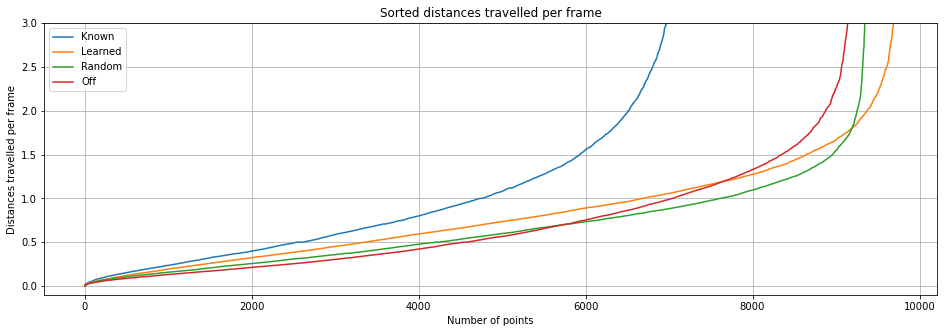

In [117]:
plt.figure(figsize=(16,5))
plt.plot(np.sort(dists_det1),label='Known')
plt.plot(np.sort(dists_learned1),label='Learned')
plt.plot(np.sort(dists_rands),label='Random')
plt.plot(np.sort(dists_offs),label='Off')
plt.legend()
plt.ylim([-.1,3])
plt.ylabel('Distances travelled per frame')
plt.xlabel('Number of points')
plt.title('Sorted distances travelled per frame');
plt.grid();

This looks like it means no light worms moved the least, followed by random, followed by learned, and THEN the known policy. Opposite of what I was expecting between known and learned.